In [1]:
#Base Libraries
import os 
import sys
import json
import csv

#Core Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygwalker as pyg
import datetime as dt
#Model Libraries
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP
#import umap.plot
from sentence_transformers import SentenceTransformer

#ML Libraries
import torch 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

In [2]:

#Importing Configs
# Define the path where config.py is located
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
database_file = config.database
database_folder = config.database_folder
bert_models = config.bert_models
bert_models_local = config.bert_models_local

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents


In [3]:
freq_ts = pd.read_csv('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling/Models/Word2Vec Models/keyword_info_ts.csv')
print(freq_ts.head())

  Year-Month-Day                 Type       Keyword  Frequency
0     2016-12-31  Citi Annual Reports      decrease         97
1     2016-12-31  Citi Annual Reports  unemployment          3
2     2016-12-31  Citi Annual Reports        crisis          1
3     2016-12-31  Citi Annual Reports      negative         28
4     2016-12-31  Citi Annual Reports      downward          0


In [4]:
freq_ts_m = freq_ts.copy(deep=True)
freq_ts_m["Year-Month"] = pd.to_datetime(freq_ts_m["Year-Month-Day"])
freq_ts_m['Year-Month'] = freq_ts_m['Year-Month'].dt.to_period('M')
print(freq_ts_m.head())

  Year-Month-Day                 Type       Keyword  Frequency Year-Month
0     2016-12-31  Citi Annual Reports      decrease         97    2016-12
1     2016-12-31  Citi Annual Reports  unemployment          3    2016-12
2     2016-12-31  Citi Annual Reports        crisis          1    2016-12
3     2016-12-31  Citi Annual Reports      negative         28    2016-12
4     2016-12-31  Citi Annual Reports      downward          0    2016-12


In [5]:
freq_ts_m = freq_ts_m.pivot_table(index='Year-Month', columns='Keyword', values='Frequency')
print(freq_ts_m.head())

Keyword     crisis  decrease  downward  negative  unemployment
Year-Month                                                    
2006-12        0.0      14.5       0.0       8.0           0.5
2007-12        3.0      19.5       1.0       7.0           0.0
2008-12        7.5      26.5       1.5      20.5           3.5
2009-12       14.0      69.0       2.0      34.5          14.0
2010-12       15.0      78.0       2.0      38.0          11.5


In [6]:
freq_ts_m.columns
freq_ts_m.reset_index(inplace=True)
print(freq_ts_m.head())

Keyword Year-Month  crisis  decrease  downward  negative  unemployment
0          2006-12     0.0      14.5       0.0       8.0           0.5
1          2007-12     3.0      19.5       1.0       7.0           0.0
2          2008-12     7.5      26.5       1.5      20.5           3.5
3          2009-12    14.0      69.0       2.0      34.5          14.0
4          2010-12    15.0      78.0       2.0      38.0          11.5


In [7]:
energy = pd.read_csv('/Users/kylenabors/Documents/Database/Other Data/Energy Prices/US Energy CPI.csv')
energy["DATE"] = pd.to_datetime(energy["DATE"]).dt.to_period('M')
freq_ts_m = freq_ts_m.merge(energy, left_on='Year-Month', right_on='DATE', how='left')
print(freq_ts_m.head())
freq_ts_m.drop(columns=['DATE'], inplace=True)

  Year-Month  crisis  decrease  downward  negative  unemployment     DATE  \
0    2006-12     0.0      14.5       0.0       8.0           0.5  2006-12   
1    2007-12     3.0      19.5       1.0       7.0           0.0  2007-12   
2    2008-12     7.5      26.5       1.5      20.5           3.5  2008-12   
3    2009-12    14.0      69.0       2.0      34.5          14.0  2009-12   
4    2010-12    15.0      78.0       2.0      38.0          11.5  2010-12   

   CPIENGSL  
0   192.700  
1   225.649  
2   176.583  
3   209.915  
4   227.130  


In [8]:
funds = pd.read_excel('/Users/kylenabors/Documents/Database/Other Data/FedFundsRate.xlsx', sheet_name='Monthly')
funds['Date Adjusted'] = funds['Date Adjusted'].dt.to_period(freq='M')
freq_ts_m = freq_ts_m.merge(funds, left_on='Year-Month', right_on='Date Adjusted', how='left')

In [9]:
cpi = pd.read_excel('/Users/kylenabors/Documents/Database/Other Data/Urban Consumer CPI.xlsx', sheet_name='Monthly')
cpi['diff'] = cpi['Value'].diff()
print(cpi.head())
cpi["Year-Month"] = pd.to_datetime(cpi["Year-Month"]).dt.to_period('M')
freq_ts_m = freq_ts_m.merge(cpi, left_on='Year-Month', right_on='Year-Month', how='left')
freq_ts_m.drop(columns=['Date Adjusted'], inplace=True)
print(freq_ts_m.head())

  Year-Month  Value  diff
0    2000-01  168.8   NaN
1    2000-02  169.8   1.0
2    2000-03  171.2   1.4
3    2000-04  171.3   0.1
4    2000-05  171.5   0.2
  Year-Month  crisis  decrease  downward  negative  unemployment  CPIENGSL  \
0    2006-12     0.0      14.5       0.0       8.0           0.5   192.700   
1    2007-12     3.0      19.5       1.0       7.0           0.0   225.649   
2    2008-12     7.5      26.5       1.5      20.5           3.5   176.583   
3    2009-12    14.0      69.0       2.0      34.5          14.0   209.915   
4    2010-12    15.0      78.0       2.0      38.0          11.5   227.130   

        DATE  FEDFUNDS    Value   diff  
0 2006-11-30      5.24  201.800  0.300  
1 2007-11-30      4.24  210.036 -0.141  
2 2008-11-30      0.16  210.228 -2.197  
3 2009-11-30      0.12  215.949 -0.381  
4 2010-11-30      0.18  219.179  0.376  


In [10]:
freq_ts_m.rename(columns={'Value_x': 'Energy CPI', 'Value_y': 'Fed Funds Rate', 'Value': 'CPI'}, inplace=True)
print(freq_ts_m.head())

  Year-Month  crisis  decrease  downward  negative  unemployment  CPIENGSL  \
0    2006-12     0.0      14.5       0.0       8.0           0.5   192.700   
1    2007-12     3.0      19.5       1.0       7.0           0.0   225.649   
2    2008-12     7.5      26.5       1.5      20.5           3.5   176.583   
3    2009-12    14.0      69.0       2.0      34.5          14.0   209.915   
4    2010-12    15.0      78.0       2.0      38.0          11.5   227.130   

        DATE  FEDFUNDS      CPI   diff  
0 2006-11-30      5.24  201.800  0.300  
1 2007-11-30      4.24  210.036 -0.141  
2 2008-11-30      0.16  210.228 -2.197  
3 2009-11-30      0.12  215.949 -0.381  
4 2010-11-30      0.18  219.179  0.376  


<Axes: xlabel='Year-Month'>

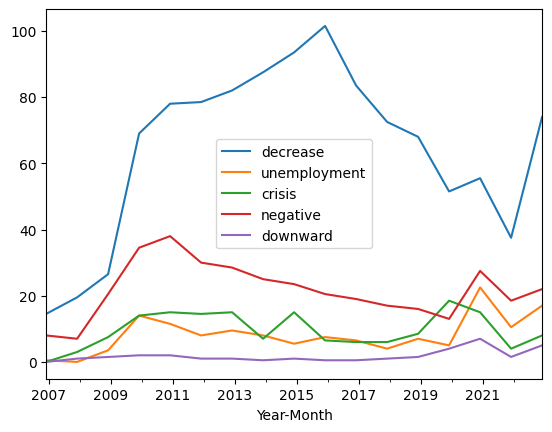

In [12]:
freq_ts_m.plot(x='Year-Month', y=["decrease", "unemployment", "crisis", "negative", "downward"])

In [13]:
gwalker = pyg.walk(freq_ts_m)

Box(children=(HTML(value='<div id="ifr-pyg-0" style="height: auto">\n    <head>\n        <meta http-equiv="Con…